# Qubit Tune-up with SHF Instruments

In this notebook we demonstrate qubit tuneup with the LabOne Q software, implemented as a sequence of experiments. 

Before starting the experiments, we define a set of initial qubit parameters, as might be known from fabrication. 

These parameters can then be used to update the baseline calibration used in the experiments.

## 0. General Imports and Definitions
### 0.1 Python Imports 

In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np

### 0.2 Function Definitions

In [2]:
# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"res_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        stop=stop_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        count=num_points,
    )

# function that returns the calibration of the readout line oscillator for spectroscopy
def res_spec_calib(frequency_sweep, amplitude_sweep=None):
   exp_calibration = Calibration()
   # sets the oscillator of the experimental measure signal
   my_osc = Oscillator(
           "readout_osc",
           frequency=frequency_sweep,
           modulation_type=ModulationType.HARDWARE,
   )
   exp_calibration["measure"] = SignalCalibration(     # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
       oscillator=my_osc,
       amplitude=amplitude_sweep,
   )
   exp_calibration["acquire"] = SignalCalibration(
       oscillator=my_osc,
   )
   return exp_calibration


# signal maps for the qubit readout only
def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

# create gaussian square pulse for readout
def create_readout_pulse(
    qubit, sigma=0.2
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined['readout_len'],
        amplitude=qubit.parameters.user_defined['readout_amp'],
        width=qubit.parameters.user_defined['readout_len'] * 0.9,
        sigma=sigma,
    )
    return readout_pulse

# qubit spectroscopy freq sweep
def create_drive_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"drive_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        stop=stop_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        count=num_points,
    )

# define square pulse for qubit spec
def create_drive_spec_pulse(qubit, amp = 0.95):
    pulse = pulse_library.const(
        uid=f"drive_spec_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=amp, #max power to start
    )
    return pulse

# signal map for qubit drive and readout
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

#define gaussian pulse for qubit drive
def create_rabi_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1,
    )

# define qubit drive rabi sweep
def create_rabi_amp_sweep(qubit, amp_num, uid="rabi_amp"):
    amp_min = 0.1
    amp_max = min([qubit.parameters.user_defined['amplitude_pi'] * 2.2, 1.0])
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

# define delay time sweep for Ramsey, T1, echo
def create_delay_sweep(
    start=0, stop=50e-6, count=100, axis_name="Time [s]"
):
    time_sweep = LinearSweepParameter(
        uid="time_sweep_param", start=start, stop=stop, count=count, axis_name=axis_name
    )
    return time_sweep

# define ramsey drive pulse
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'] / 2,
    )

# define T1 drive pulse
def create_T1_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

def create_pi_2_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_2_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']/2,
    )

def create_pi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

## 1. Define the Instrument Setup and Required Experimental Parameters
### 1.1 Create device setup

Create the device setup from the descriptor, and apply some convenient mapping to instruments and logical signals.

In [3]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12195
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/PLUS/QC6CH

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/2/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

In [4]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

### 1.2 Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings

May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [5]:
q0 = Transmon.from_logical_signal_group(
    "q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.15e9,     #Drive frequency for qubit ge transition
        resonance_frequency_ef=2.95e9,     #Drive frequency for qubit ef transtion
        drive_lo_frequency=3e9,          #Center frequency for qubit drive, needs to be within 500 MHz of both ge and ef frequencies
        readout_resonator_frequency=6421875620, #Readout frequency for readout resonator
        readout_lo_frequency=6.5e9,        #Center frequency for readout line, shared node, all qubits need to have the same value
        readout_integration_delay=60e-9,       #Propogation delay for readout aqcuire line, relative to default 212 ns, shared node, all qubits need to have the same value
        drive_range = 10,                  #Output range for qubit drive in dBm
        readout_range_out = -0,             #Output range for readout resonator in dBm, shared node, all qubits need to have the same value
        readout_range_in = -15,              #Input range for readout resonator in dBm, shared node, all qubits need to have the same value
        
        user_defined={                     #Pulse Parameters to be included as user_defined
            "amplitude_pi": 0.99,           #Amplitude of Pi pulse, linear gain from 0 to 1 of drive_range
            "pulse_length": 50e-9,         #Length of drive/Pi pulse
            "readout_len": 2e-6,           #Length of readout pulse
            "readout_amp": 0.98,           #Amplitude of readout pulse, linear gain from 0 to 1 of readout_range_out, starts at 1 for spectroscopy
            "reset_length": 5e-6,          #Relaxation time to return to ground state
        },
    ),
)

q1 = Transmon.from_logical_signal_group(
    "q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.25e9,
        resonance_frequency_ef=2.99e9,
        drive_lo_frequency=7.1e9,
        readout_resonator_frequency=6586776100,
        readout_lo_frequency=q0.parameters.readout_lo_frequency, #Shared node, needs to match q0 center frequency
        readout_integration_delay=q0.parameters.readout_integration_delay, #Shared node, needs to match q0
        drive_range = 10,
        readout_range_out = q0.parameters.readout_range_out, #Shared node, needs to match q0
        readout_range_in = q0.parameters.readout_range_in, #Shared node, needs to match q0
        user_defined={
            "amplitude_pi": 0.6,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.98,
            "reset_length": 5e-6,
        },
    ),
)

In [6]:
#Finish calibrating SHFQC with qubit parameters
qubits = [q0, q1]
for qubit in qubits:
    device_setup.set_calibration(qubit.calibration())

#Choose which qubit will be measured
measure_q = q0

### 2.2 Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments

In [7]:
# perform experiments in emulation mode or on hardware - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.10.10 08:59:15.213] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\Users\QNL\ZIScripts\LabOneQ\laboneq_output\log
[2024.10.10 08:59:15.215] INFO    VERSION: laboneq 2.36.0
[2024.10.10 08:59:15.217] INFO    Connecting to data server at localhost:8004
[2024.10.10 08:59:15.627] INFO    Configuring the device setup
[2024.10.10 08:59:15.643] INFO    The device setup is configured


## 3. Qubit Tuneup - Experimental Sequence

Sequence of experiments for tuneup from scratch of a superconducting qubit in circuit QED architecture 

### 3.1 Resonator Spectroscopy: CW

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line

#### 3.1.1 Additional Experimental Parameters

Define the frequency scan

#### 3.1.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [8]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec

#### 3.1.3 Run and Evaluate Experiment
Runs the experiment and evaluates the data returned by the measurement

In [9]:
measure_q.parameters.readout_range_out = -5
measure_q.parameters.readout_range_in = 5
# measure_q.parameters.readout_range_out = 10
# measure_q.parameters.readout_range_in = 5
measure_q.parameters.user_defined['readout_amp'] = 0.9

In [10]:
# measure_q.parameters.readout_lo_frequency = 6.5e9
# measure_q.parameters.readout_resonator_frequency = 6.5e9

In [11]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=3000000000.0,
│   │   readout_resonator_frequency=64218756200,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-5,
│   │   readout_range_in=5,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 5e-06
│   │   }
│   )
)

In [12]:
device_setup.set_calibration(measure_q.calibration())

In [13]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -1e6
stop_freq = 1e6
num_points = 101
integration_time = 6e-2
num_averages = 1

In [14]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [15]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.10.10 08:59:20.972] INFO    Starting LabOne Q Compiler run...
[2024.10.10 08:59:20.973] WARNING Setting the local oscillator frequency of signal 'acquire' to 6.5 GHz may yield unpredictable phase relationships between different channels.
It is highly recommended to choose a frequency that is an integer multiple of 200 MHz.
[2024.10.10 08:59:20.974] WARNING Setting the local oscillator frequency of signal 'measure' to 6.5 GHz may yield unpredictable phase relationships between different channels.
It is highly recommended to choose a frequency that is an integer multiple of 200 MHz.
[2024.10.10 08:59:21.099] INFO    Schedule completed. [0.123 s]
[2024.10.10 08:59:21.113] INFO    Code generation completed for all AWGs. [0.025 s]
[2024.10.10 08:59:21.126] INFO    Completed compilation step 1 of 1. [0.150 s]
[2024.10.10 08:59:21.129] INFO     ────────────────────────────────────────────────────────────────── 
[2024.10.10 08:59:21.130] INFO      Device         AWG   SeqC LOC   CT entri

LabOneQException: seq_device_shfqc_0_[].seqc: AWG compilation failed.
Compilation failed: Compiler Error (line: 3): invalid value for argument 1 of function configFreqSweep


In [ ]:
electrical_delay = 90e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
# _phase = _delay*spec_freq*np.angle(spec_res)
# ax2.plot(spec_freq / 1e9, _phase, "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(6582311900.0/1e9)

plt.show()

# R6, Q0 (F-C0)

In [79]:
measure_q.parameters.readout_range_out = -10
measure_q.parameters.readout_range_in = 0

In [80]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [81]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -20e6
stop_freq = 20e6
num_points = 201
integration_time = 5e-2
num_averages = 1

In [82]:
res = (stop_freq + (-start_freq))/(num_points*1e6)
print(f'resolution = {res} MHz')

resolution = 0.19900497512437812 MHz


In [83]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [84]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.07.29 14:54:55.882] INFO    Starting LabOne Q Compiler run...
[2024.07.29 14:54:55.956] INFO    Schedule completed. [0.066 s]
[2024.07.29 14:54:56.043] INFO    Code generation completed for all AWGs. [0.084 s]
[2024.07.29 14:54:56.046] INFO    Completed compilation step 1 of 1. [0.157 s]
[2024.07.29 14:54:56.056] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 14:54:56.059] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 14:54:56.062] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 14:54:56.064] INFO      device_shfqc     0         25            0           0         0  
[2024.07.29 14:54:56.067] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 14:54:56.069] INFO      TOTAL                      25            0                     0  
[2024.07.29 14:54:56.071] INFO     ────────────────────────────────────────────────────

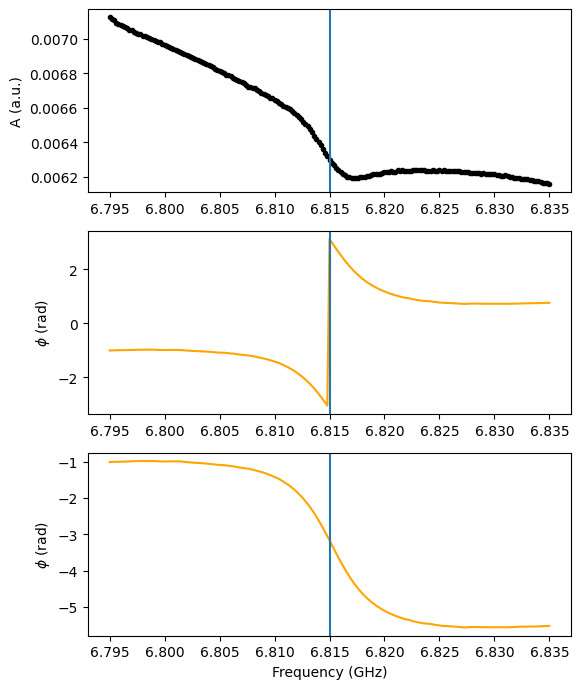

In [90]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.815]
for _vl in vl:
    ax1.axvline(vl, ls='-', color='tab:blue')
    ax2.axvline(vl, ls='-', color='tab:blue')
    ax3.axvline(vl, ls='-', color='tab:blue')

plt.tight_layout()
plt.show()

## center freq fit

In [ ]:
#Lorentzian fit requires roughly close starting values
(p_opt, b) = lorentzian.fit(
    spec_freq,
    abs(spec_res),
    100e3,
    q0.parameters.readout_resonator_frequency,
    -1e7,
    1,
    plot=True,
)
opt_freq = p_opt[1]
print(f"Resonant frequency: {opt_freq} GHz")

## Punch out 

In [124]:
measure_q.parameters.readout_range_out = -20
measure_q.parameters.readout_range_in = -10

In [125]:
# measure_q.parameters.readout_lo_frequency
measure_q.parameters.readout_resonator_frequency = 6.815e9

In [126]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [166]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -10e6
stop_freq = 10e6
num_points = 201
integration_time = 5e-2
num_averages = 1

In [167]:
# set number of points for amplitude sweep
num_amp_points = 21

In [168]:
device_setup.set_calibration(measure_q.calibration())

#### 3.3.2 Experiment Definition

In [169]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep and amplitude sweeps as parameters


def res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive amplitude
    with exp_spec.sweep(uid="res_amp", parameter=amplitude_sweep):
        with exp_spec.acquire_loop_rt(
            uid="shots",
            count=2**num_averages,
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            #inner loop - sweep frequency
            with exp_spec.sweep(uid="res_freq", parameter=frequency_sweep):
                # readout pulse and data acquisition
                with exp_spec.section(uid="spectroscopy"):
                    # play resonator excitation pulse
                    exp_spec.play(signal="measure", pulse=readout_pulse)
                    # resonator signal readout
                    exp_spec.acquire(
                        signal="acquire",
                        handle="res_spec_pulsed",
                        length=readout_pulse.length,
                    )
                with exp_spec.section(uid="delay"):
                    # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                    exp_spec.delay(signal="measure", time=1e-6)

    return exp_spec

#### 3.3.3 Apply Experiment Parameters and Compile

In [170]:
num_freq_points = num_points

In [171]:
amplitude_sweep = LinearSweepParameter(
    uid="amp_sweep_param", start=0.01, stop=0.99, count=num_amp_points
)

readout_pulse = create_readout_pulse(measure_q)
frequency_sweep = create_readout_freq_sweep(
    measure_q, start_freq, stop_freq, num_freq_points
)

exp_spec_amp = res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
)

exp_spec_amp.set_calibration(res_spec_calib(frequency_sweep, amplitude_sweep))
exp_spec_amp.set_signal_map(res_spec_map(measure_q))

In [172]:
# compile the experiment on the open instrument session
compiled_spec_amp = session.compile(exp_spec_amp)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet(
    "Pulse_Sheets/Spectroscopy_vs_Amplitude_Pulse_Sheet", compiled_spec_amp
)

[2024.07.29 15:16:59.997] INFO    Starting LabOne Q Compiler run...
[2024.07.29 15:17:00.016] INFO    Schedule completed. [0.016 s]
[2024.07.29 15:17:00.070] INFO    Code generation completed for all AWGs. [0.053 s]
[2024.07.29 15:17:00.072] INFO    Completed compilation step 1 of 21. [0.072 s]
[2024.07.29 15:17:00.073] INFO    Skipping compilation for next step(s)...
[2024.07.29 15:17:00.076] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 15:17:00.077] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 15:17:00.079] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 15:17:00.080] INFO      device_shfqc     0         21            0           1      8000  
[2024.07.29 15:17:00.081] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 15:17:00.082] INFO      TOTAL                      21            0                  8000  
[2024.07.29

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Spectroscopy_vs_Amplitude_Pulse_Sheet_2024-07-29-15-17-00.html

In [173]:
# run the compiled experiemnt
spec_amp_results = session.run(compiled_spec_amp)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_amp_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_amp_results_{timestamp}.json")

[2024.07.29 15:17:00.225] INFO    Configuring the device setup
[2024.07.29 15:17:00.330] INFO    The device setup is configured
[2024.07.29 15:17:01.261] INFO    Starting near-time execution...
[2024.07.29 15:17:15.410] INFO    Finished near-time execution.
File saved as Results_Needed/spec_amp_results_20240729T151715.json


#### plot results

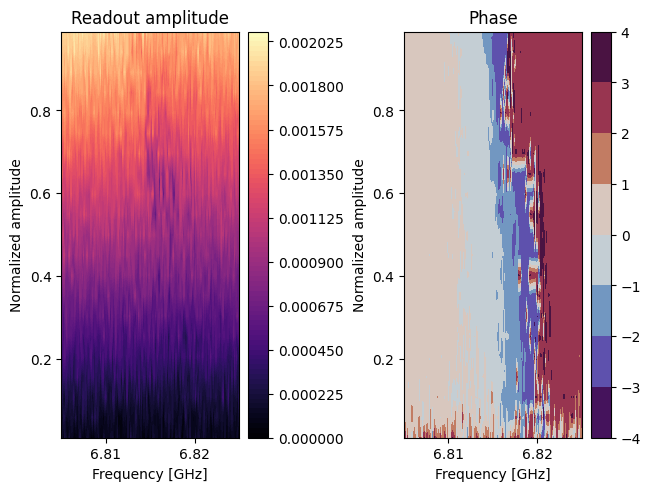

In [174]:
# plot the results
lo_freq = measure_q.parameters.readout_lo_frequency
spec_freq = lo_freq + spec_amp_results.get_axis("res_spec_pulsed")[1]
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

X, Y = np.meshgrid(spec_freq, amp)
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
CS = ax[0].contourf(X / 1e9, Y, np.abs(data), levels=100, cmap="magma")
ax[0].set_title("Readout amplitude")
ax[0].set_xlabel("Frequency [GHz]")
ax[0].set_ylabel("Normalized amplitude")
fig.colorbar(CS)

max_value = (
    max(
        # int(np.abs(np.min(np.unwrap(np.angle(data, deg=False))))),
        # int(np.abs(np.max(np.unwrap(np.angle(data, deg=False))))),
        int(np.abs(np.min(np.angle(data, deg=False)))),
        int(np.abs(np.max(np.angle(data, deg=False)))),
    )
    + 1
)

cs2_levels = np.linspace(-max_value, max_value, 2 * (max_value) + 1)

CS2 = ax[1].contourf(
    X / 1e9,
    Y,
    # np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data)),
    np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data),
    levels=cs2_levels,
    cmap="twilight_shifted",
)
ax[1].set_title("Phase")
ax[1].set_xlabel("Frequency [GHz]")
ax[1].set_ylabel("Normalized amplitude")
fig.colorbar(CS2)

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_47976\3415874774.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, [ax1, ax2] = plt.subplots(2, 1)


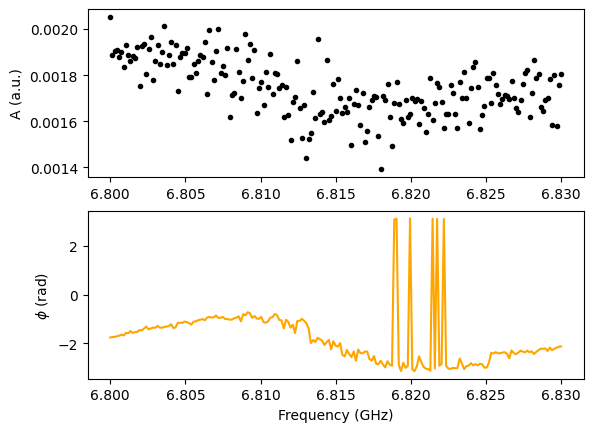

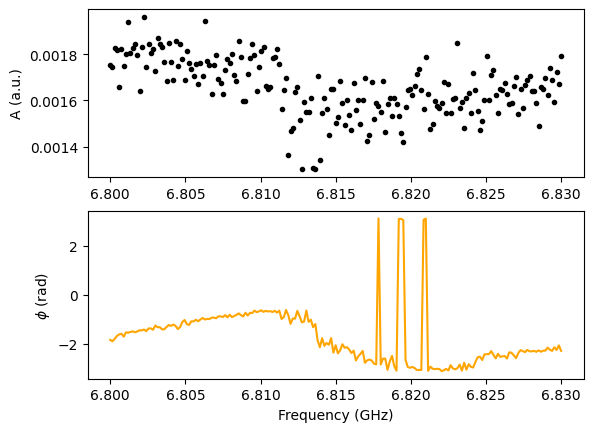

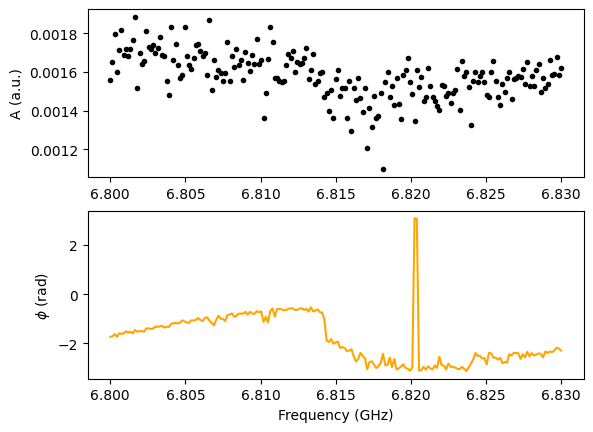

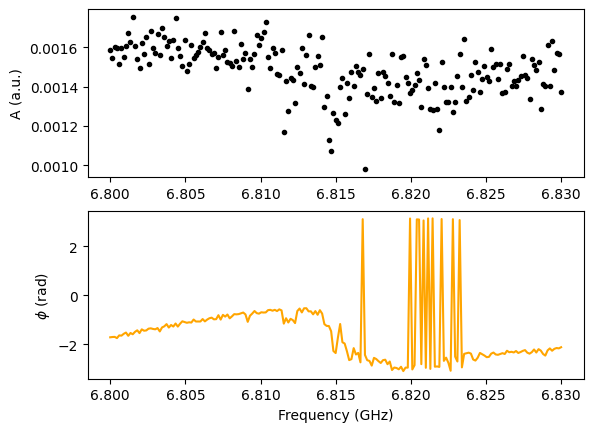

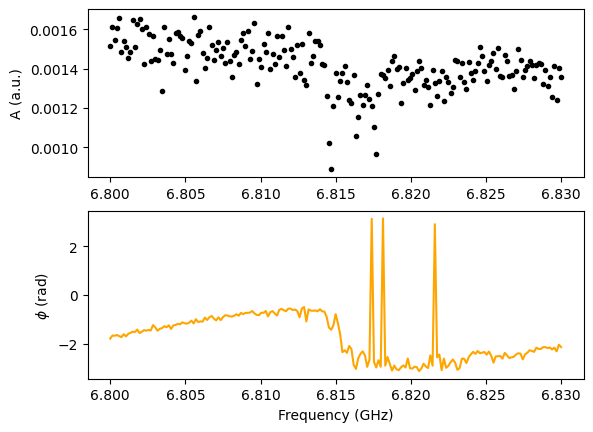

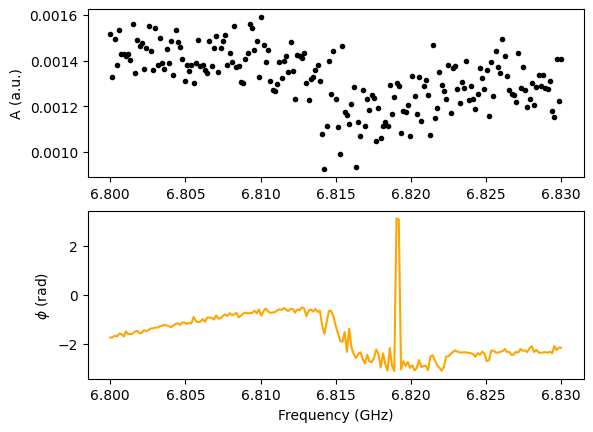

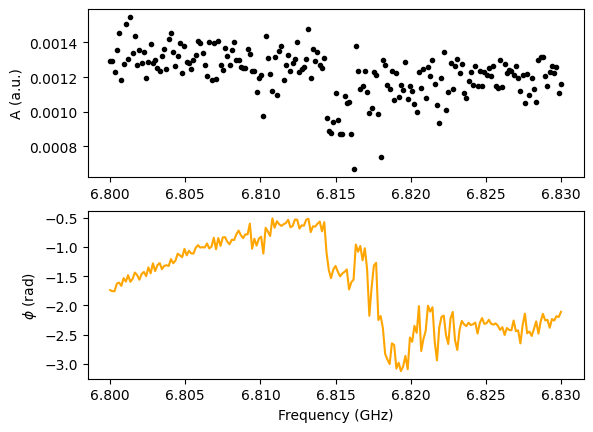

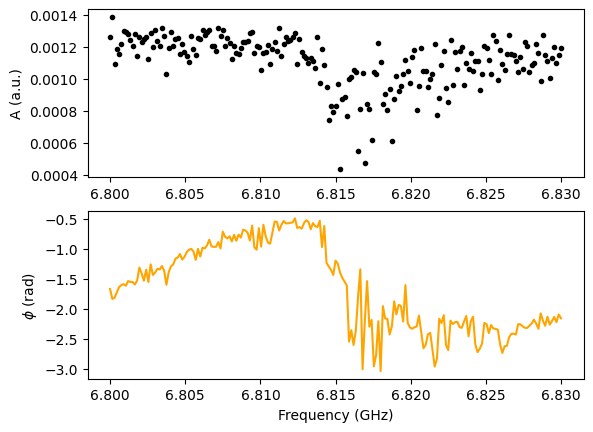

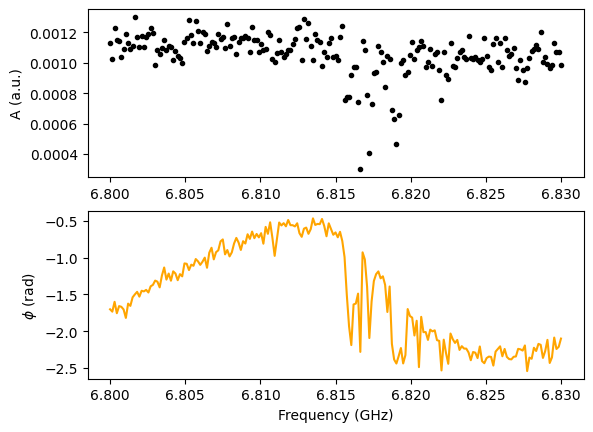

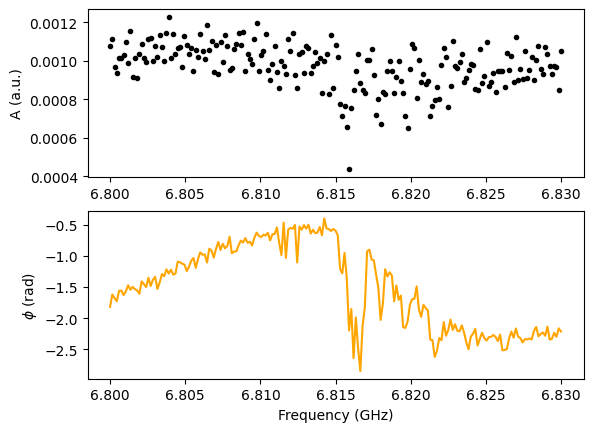

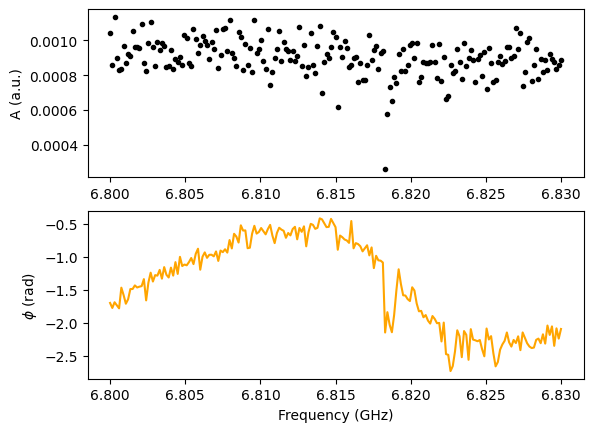

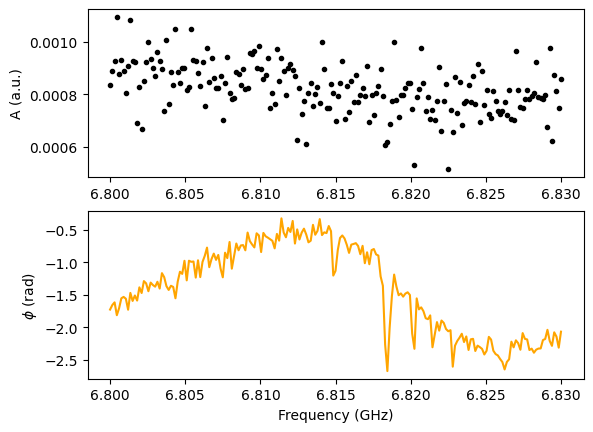

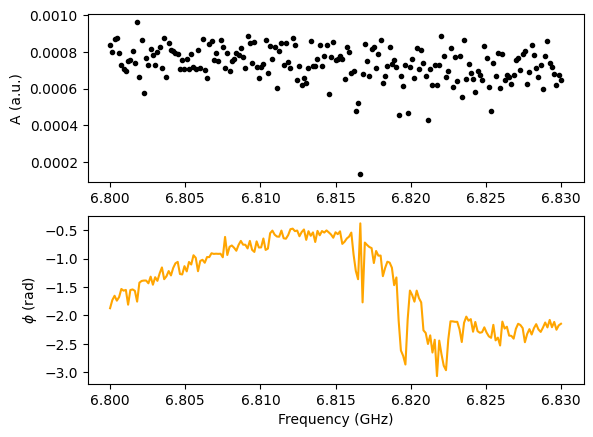

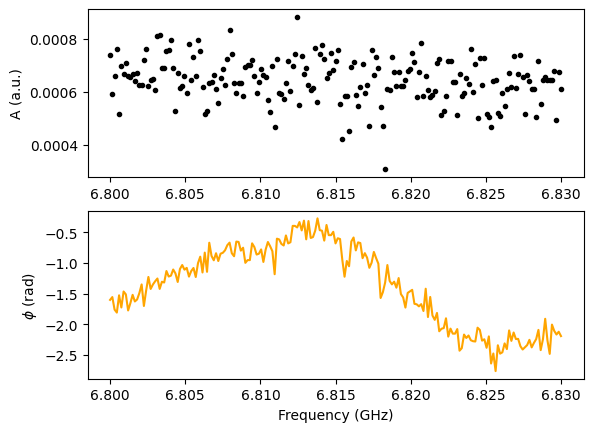

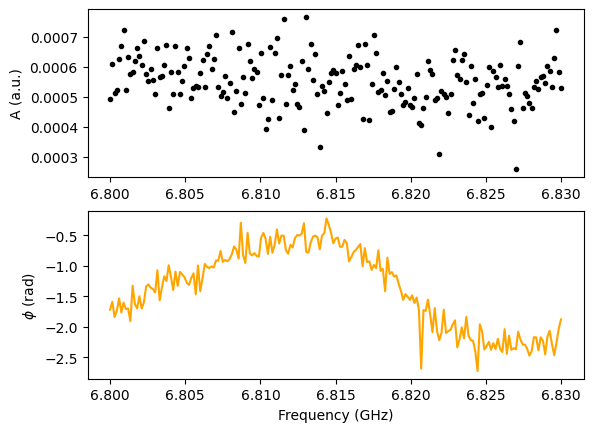

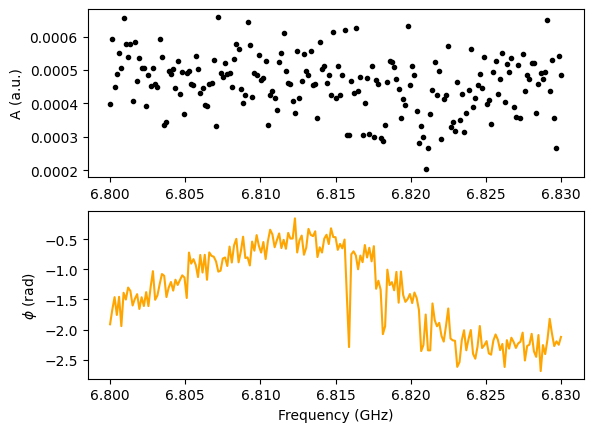

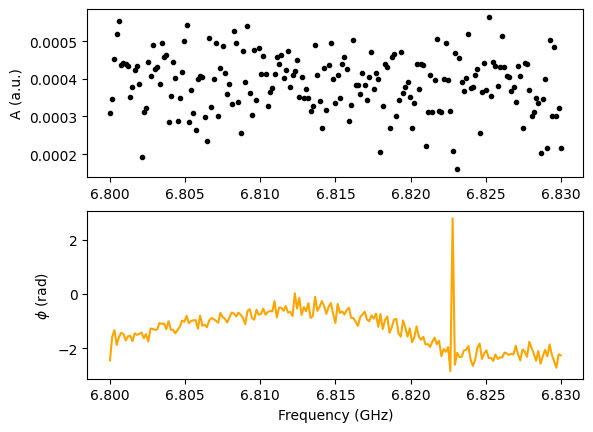

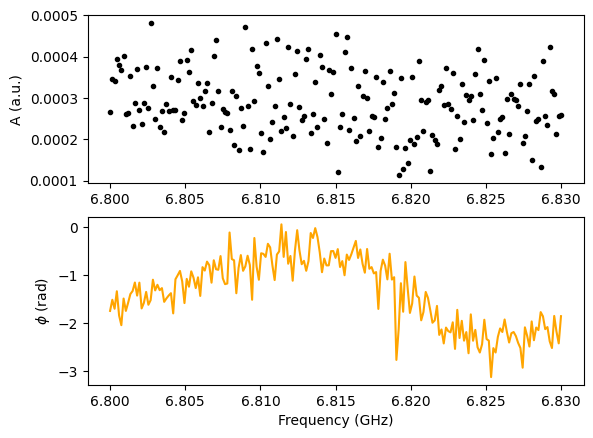

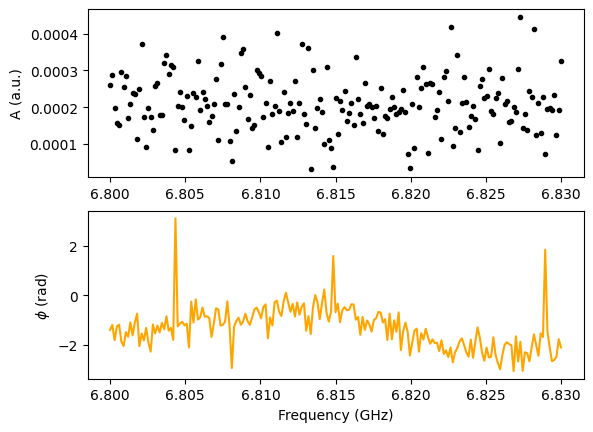

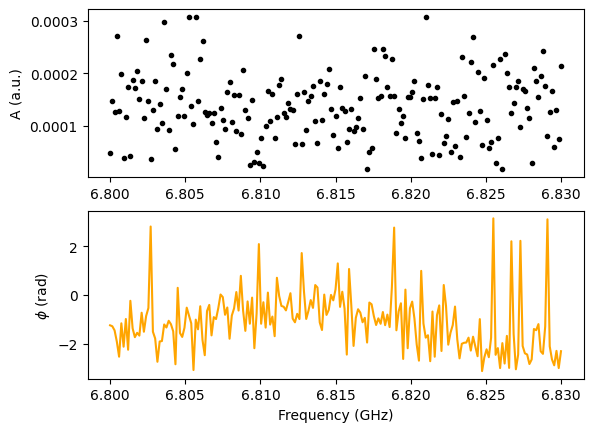

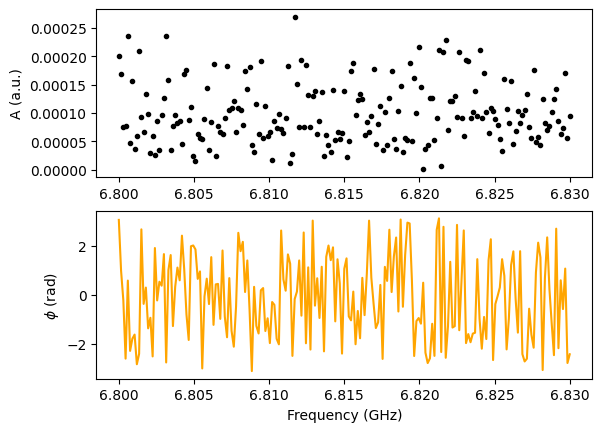

In [175]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
spec_freq = (
    measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
)
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

np.shape(spec_res)
np.shape(spec_freq)
np.shape(data)

for d in np.flip(data, axis=0):
# for d in data:
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = d
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[1]
    )

    emulate=False
    if emulate:
        # create some dummy data if running in emulation mode
        spec_res = lorentzian(
            spec_freq,
            10e6,
            measure_q.parameters.readout_resonator_frequency * (0.995 + 0.01 * np.random.rand(1)[0]),
            -2e6,
            1,
        ) + 0.1 * np.random.rand(len(spec_freq))
    
    # plot the measurement data
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
    ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
    ax1.set_ylabel("A (a.u.)")
    ax2.set_ylabel("$\\phi$ (rad)")
    ax2.set_xlabel("Frequency (GHz)")
    # ax2.axvline(spec_freq[np.argmin(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res))]/1e9)
    # spec_freq[np.argmin(abs(spec_res))]/1e9

Text(0.5, 1.0, 'Punchout phase')

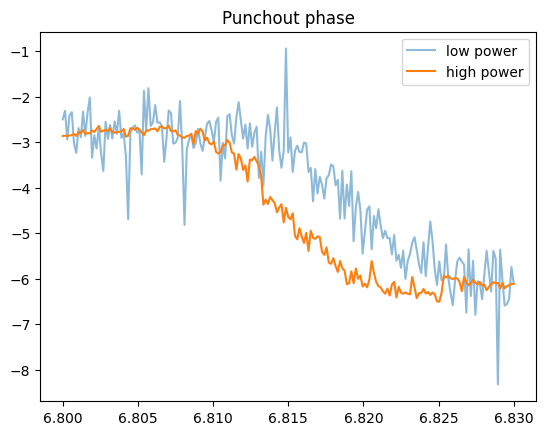

In [189]:
electrical_delay = 45.68e-9
alpha=0.5
plt.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*(data[2]))), label='low power', alpha=alpha)
plt.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*(data[-1]))), label='high power', alpha=1)
plt.legend()
plt.title('Punchout phase')

In [355]:
measure_q.parameters.user_defined['readout_range_out'] = -20
measure_q.parameters.user_defined['readout_range_in'] = -15
measure_q.parameters.user_defined['readout_amp'] = 0.1
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1100000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1100000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [547]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163500000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

## Resonator vs flux 

### resonator spectroscopy setup

In [538]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -4e6
stop_freq = 15e6
num_points = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

readout_pulse = create_readout_pulse(measure_q)

In [539]:
2**10

1024

In [540]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163500000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

#### 3.2.2 Experiment Definition

In [541]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [542]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [543]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [544]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.29 16:57:50.475] INFO    Starting LabOne Q Compiler run...
[2024.07.29 16:57:50.485] INFO    Schedule completed. [0.007 s]
[2024.07.29 16:57:50.513] INFO    Code generation completed for all AWGs. [0.027 s]
[2024.07.29 16:57:50.514] INFO    Completed compilation step 1 of 1. [0.037 s]
[2024.07.29 16:57:50.517] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 16:57:50.518] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 16:57:50.520] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 16:57:50.521] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.29 16:57:50.522] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 16:57:50.523] INFO      TOTAL                      23            0                  8000  
[2024.07.29 16:57:50.525] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-29-16-57-50.html

#### 3.2.4 Run and Evaluate Experiment

In [545]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.29 16:57:59.035] INFO    Configuring the device setup
[2024.07.29 16:57:59.147] INFO    The device setup is configured
[2024.07.29 16:58:00.173] INFO    Starting near-time execution...
[2024.07.29 16:58:01.791] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240729T165801.json


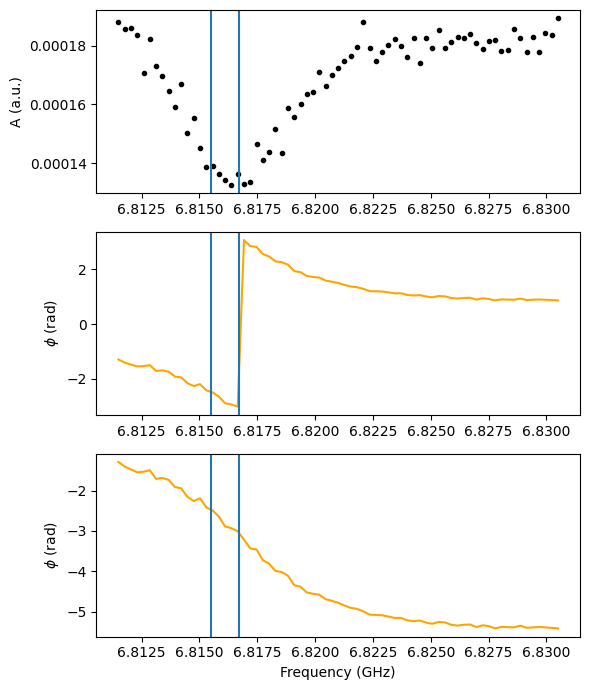

In [558]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.8155, 6.8167]
for _vl in vl:
    ax1.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax2.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax3.axvline(_vl, ls='-', 
                # color='tab:blue',
               )

plt.tight_layout()
plt.show()

### f_r vs phi ext

In [365]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.02s


KeyError: 'Another instrument has the name: yoko'

In [237]:
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [238]:
dc.output('off')
dc.source_mode('CURR')

In [239]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

In [240]:
import sys

In [254]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)

start_curr = 0.10e-3
stop_curr = 0.40e-3
current_sweep = np.linspace(start_curr,stop_curr, 101)

dc.ramp_current(0e-3, 1e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

dc.ramp_current(0,0.5e-6,0)
dc.output('off')

step 0
current: 0.0001
[2024.07.29 15:34:44.093] INFO    Configuring the device setup
[2024.07.29 15:34:44.207] INFO    The device setup is configured
[2024.07.29 15:34:45.804] INFO    Starting near-time execution...
[2024.07.29 15:34:47.512] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240729T153447.json
step 1
current: 0.00010300000000000001
[2024.07.29 15:34:49.286] INFO    Starting near-time execution...
[2024.07.29 15:34:50.998] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240729T153451.json
step 2
current: 0.000106
[2024.07.29 15:34:52.471] INFO    Starting near-time execution...
[2024.07.29 15:34:54.236] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240729T153454.json
step 3
current: 0.000109
[2024.07.29 15:34:55.899] INFO    Starting near-time execution...
[2024.07.29 15:34:57.615] INFO    Finished near-time execution.
File saved as Results_Needed/s

Text(0.5, 1.0, 'LogMag [arb.]')

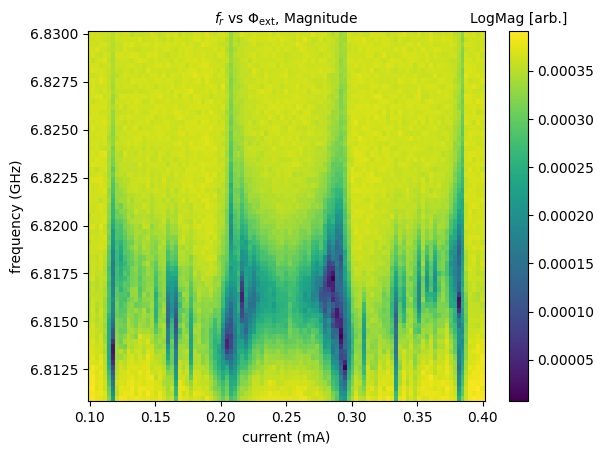

In [255]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

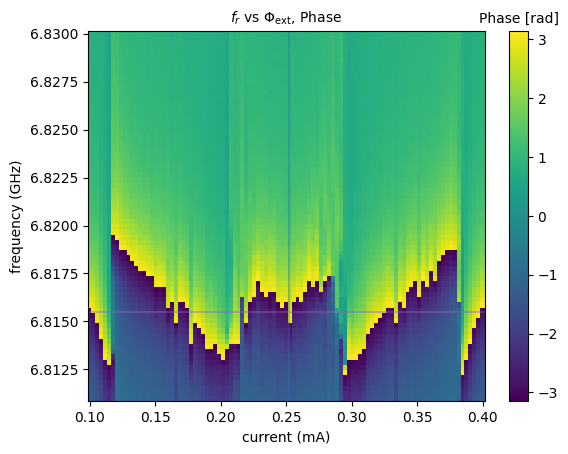

In [263]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.252, c='tab:blue', alpha=0.4)
plt.axhline(6.8155, c='tab:purple', alpha=0.4)

# Two-tone

In [367]:
dc.ramp_current(0.252e-3, 0.5e-6, 0)

In [366]:
dc.output('on')

In [635]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
# qspec_num = 1001
qspec_num = 401

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

In [623]:
measure_q?

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163500000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=0,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.2,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

In [767]:
### QB spec
measure_q.parameters.drive_lo_frequency = 1.3e9

LF_path = False
start_freq = -20e6
stop_freq = 20e6
measure_q.parameters.resonance_frequency_ge = 1.1635e9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
# measure_q.parameters.user_defined['amplitude_pi'] = 0.1

### RO spec
measure_q.parameters.readout_resonator_frequency = 6.8155e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3


# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

measure_q.parameters.drive_range = 5
# measure_q.parameters.drive_range = -10
measure_q.parameters.user_defined['reset_length'] = 1e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 2000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163500000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [768]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [769]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [770]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [771]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [772]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(1e-06,
 LinearSweepParameter(uid='drive_freq_q0', start=-156500000.0, stop=-116500000.0, count=401, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q0', amplitude=0.95, length=2e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q0', amplitude=0.1, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [773]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.29 17:44:01.717] INFO    Starting LabOne Q Compiler run...
[2024.07.29 17:44:01.760] INFO    Schedule completed. [0.040 s]
[2024.07.29 17:44:02.029] INFO    Code generation completed for all AWGs. [0.267 s]
[2024.07.29 17:44:02.031] INFO    Completed compilation step 1 of 1. [0.311 s]
[2024.07.29 17:44:02.035] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 17:44:02.036] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 17:44:02.038] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 17:44:02.039] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.29 17:44:02.040] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.29 17:44:02.041] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 17:44:02.042] INFO      TOTAL                         32 

In [774]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.29 17:44:02.054] INFO    Configuring the device setup
[2024.07.29 17:44:02.157] INFO    The device setup is configured
[2024.07.29 17:44:03.338] INFO    Starting near-time execution...
[2024.07.29 17:44:03.911] INFO    Estimated RT execution time: 16.71 s.
[2024.07.29 17:44:20.910] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240729T174421.json


In [775]:
emulate=False

estimated frequency 1.1778 GHz


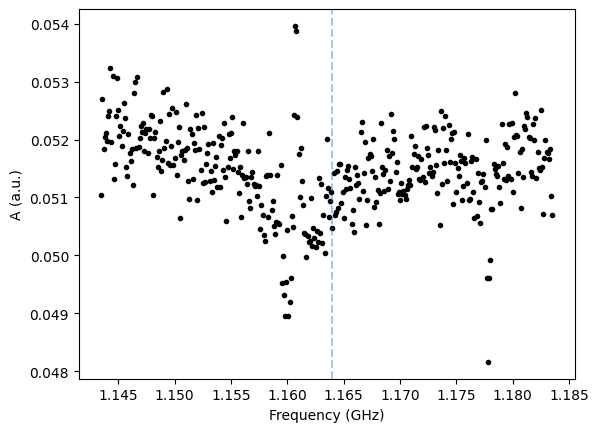

In [844]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

plt.axvline(1.164, linestyle = '--', alpha=0.4)
# plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(abs(qspec_res))]/1e9) + ' GHz')
plt.show()

In [845]:
measure_q.parameters.resonance_frequency_ge = 1.164e9
# measure_q.parameters.resonance_frequency_ge = 1.160e9
device_setup.set_calibration(
    measure_q.calibration()
)

### 3.6 Amplitude Rabi Experiment

Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles

#### 3.6.1 Additional Experimental Parameters

Define the amplitude sweep range and qubit excitation pulse

In [846]:
# measure_q.parameters.resonance_frequency_ge = 5.4
# measure_q.parameters.user_defined['pulse_length'] = 50e-9
measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1164000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [847]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 40
amp_min=0.0
amp_max=0.99


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [848]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [849]:
def create_rabi_amp_sweep(qubit, amp_num, amp_min=0.1, amp_max=0.22, uid="rabi_amp"):
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

In [850]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes, amp_min=amp_min, amp_max=amp_max), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.07.29 17:56:49.645] INFO    Starting LabOne Q Compiler run...
[2024.07.29 17:56:49.651] INFO    Schedule completed. [0.004 s]
[2024.07.29 17:56:49.690] INFO    Code generation completed for all AWGs. [0.037 s]
[2024.07.29 17:56:49.691] INFO    Completed compilation step 1 of 1. [0.044 s]
[2024.07.29 17:56:49.694] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 17:56:49.695] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 17:56:49.697] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 17:56:49.698] INFO      device_shfqc        0         11            0           1      8000  
[2024.07.29 17:56:49.699] INFO      device_shfqc_sg     0        131           40           2     16000  
[2024.07.29 17:56:49.701] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 17:56:49.702] INFO      TOTAL                        142 

#### 3.6.4 Show Pulse Sheet

In [851]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.07.29 17:56:49.712] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.29 17:56:49.715] INFO    Starting LabOne Q Compiler run...
[2024.07.29 17:56:49.724] INFO    Schedule completed. [0.007 s]
[2024.07.29 17:56:49.760] INFO    Code generation completed for all AWGs. [0.034 s]
[2024.07.29 17:56:49.761] INFO    Completed compilation step 1 of 1. [0.044 s]
[2024.07.29 17:56:49.763] INFO    Finished LabOne Q Compiler run.
[2024.07.29 17:56:49.777] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-29-17-56-49.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-29-17-56-49.html

#### 3.6.5 Plot Simulated Outputs

In [852]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [853]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.07.29 17:56:49.821] INFO    Configuring the device setup
[2024.07.29 17:56:49.929] INFO    The device setup is configured
[2024.07.29 17:56:50.852] INFO    Starting near-time execution...
[2024.07.29 17:56:51.371] INFO    Estimated RT execution time: 34.08 s.
[2024.07.29 17:57:25.707] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240729T175725.json


In [854]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = oscillatory(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(
        len(rabi_amp)
    )

Fitted parameters: [ 8.54560943e+00  1.51755859e+00  9.36580083e-04 -1.03564484e-02]


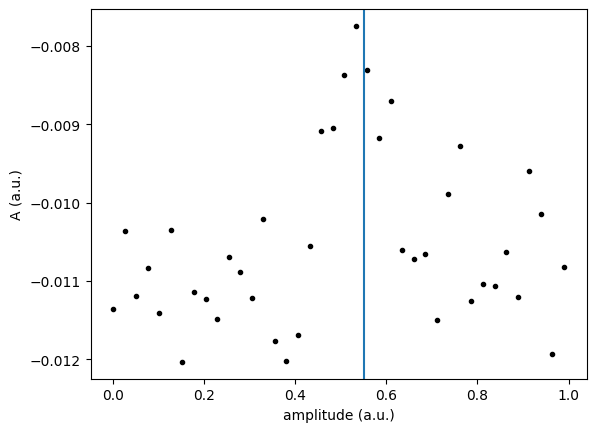

In [870]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
plt.axvline(0.55)
# pi_amp = 0.95

In [871]:
# rabi_amplitude = pi_amp
measure_q.parameters.user_defined['amplitude_pi'] = 0.55

# T1

#### 3.7.1 Experiment Parameters

In [872]:
# measure_q.parameters.user_defined['amplitude_pi'] = 0.95
# measure_q.parameters.user_defined['pulse_length'] = 20e-6
# measure_q.parameters.drive_range = 10

In [873]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1164000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.55,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [874]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 40
start_delay = 0e-6
stop_delay = 200e-6


#### 3.7.2 Experiment Definition

In [875]:
# function that returns a T1 experiment


def T1(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_T1 = Experiment(
        uid="T1 Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define T1 experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_T1.acquire_loop_rt(
        uid="T1_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        
        # inner loop - real time sweep of T1 time delays
        with exp_T1.sweep(
            uid="T1_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - delay is swept
            with exp_T1.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_T1.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_T1.delay(signal="drive", time=time_sweep)
            # readout pulse and data acquisition
            with exp_T1.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_T1.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_T1.acquire(
                    signal="acquire",
                    handle="T1",
                    kernel=readout_pulse,
                )
            with exp_T1.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_T1.reserve(signal="measure")
    return exp_T1

#### 3.7.3 Create Experiment and Signal Map

In [876]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_T1_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

T1_exp = T1(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

T1_exp.set_signal_map(signal_map_default(measure_q))

compiled_T1 = session.compile(T1_exp)

[2024.07.29 18:00:18.528] INFO    Starting LabOne Q Compiler run...
[2024.07.29 18:00:18.535] INFO    Schedule completed. [0.005 s]
[2024.07.29 18:00:18.573] INFO    Code generation completed for all AWGs. [0.036 s]
[2024.07.29 18:00:18.574] INFO    Completed compilation step 1 of 1. [0.044 s]
[2024.07.29 18:00:18.577] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 18:00:18.578] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 18:00:18.579] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 18:00:18.580] INFO      device_shfqc        0        221            0           1      8000  
[2024.07.29 18:00:18.581] INFO      device_shfqc_sg     0        241           16          16    128480  
[2024.07.29 18:00:18.582] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 18:00:18.584] INFO      TOTAL                        462 

#### 3.7.4 Show Pulse Sheet

In [877]:
show_pulse_sheet("Pulse_Sheets/T1", compiled_T1)

[2024.07.29 18:00:18.592] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.29 18:00:18.596] INFO    Starting LabOne Q Compiler run...
[2024.07.29 18:00:18.605] INFO    Schedule completed. [0.007 s]
[2024.07.29 18:00:18.679] INFO    Code generation completed for all AWGs. [0.073 s]
[2024.07.29 18:00:18.681] INFO    Completed compilation step 1 of 1. [0.083 s]
[2024.07.29 18:00:18.682] INFO    Finished LabOne Q Compiler run.
[2024.07.29 18:00:18.697] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-07-29-18-00-18.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-07-29-18-00-18.html

#### 3.7.5 Plot Simulated Outputs

In [878]:
# plot_simulation(compiled_T1, 100e-6, 150e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [879]:
# run the compiled experiemnt
T1_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/T1_results_{timestamp}.json")
print(f"File saved as Results_Needed/T1_results_{timestamp}.json")

[2024.07.29 18:00:18.741] INFO    Configuring the device setup
[2024.07.29 18:00:18.858] INFO    The device setup is configured
[2024.07.29 18:00:20.154] INFO    Starting near-time execution...
[2024.07.29 18:00:20.740] INFO    Estimated RT execution time: 66.85 s.
[2024.07.29 18:01:27.827] INFO    Finished near-time execution.
File saved as Results_Needed/T1_results_20240729T180127.json


In [880]:
# get measurement data returned by the instruments
T1_res = T1_results.get_data("T1")

# define time axis from qubit parameters
T1_delay = T1_results.get_axis("T1")[0]

if emulate:
    # create dummy data if running in emulation mode
    T1_res = exponential_decay(
        T1_delay, 2e5, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(T1_delay))

Text(0.5, 0, 'delay (us)')

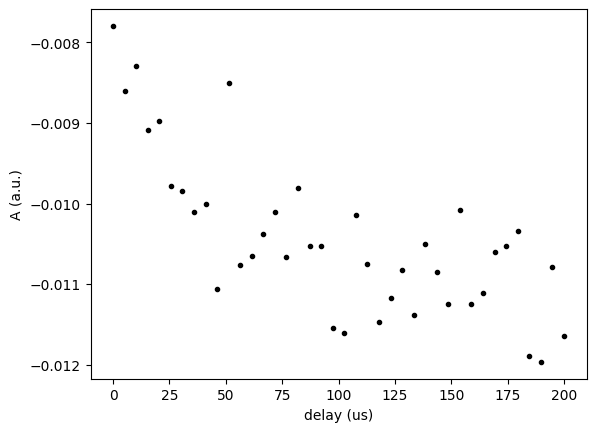

In [881]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay*1e6, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

Fitted parameters: [ 2.41430580e+04 -1.10884897e-02  3.09581237e-03]
T1 time 41.419773689127844 us


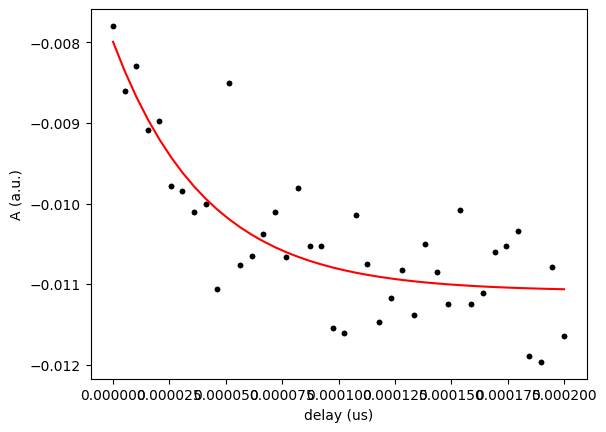

In [882]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

# increase number of plot points for smooth plotting of fit results
#delay_plot = np.linspace(T1_delay[0], T1_delay[-1], 5 * len(T1_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = exponential_decay.fit(
   T1_delay,
   T1_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 
# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

# Wide range two-tone sweep

In [367]:
dc.ramp_current(0.252e-3, 0.5e-6, 0)

In [366]:
dc.output('on')

In [885]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
# qspec_num = 1001
qspec_num = 3001

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

In [884]:
measure_q?

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1164000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.55,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

In [896]:
### QB spec
measure_q.parameters.drive_lo_frequency = 1.2e9

LF_path = False
start_freq = -200e6
stop_freq = 300e6
measure_q.parameters.resonance_frequency_ge = 0.9e9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
# measure_q.parameters.user_defined['amplitude_pi'] = 0.1

### RO spec
measure_q.parameters.readout_resonator_frequency = 6.8155e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3


# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

measure_q.parameters.drive_range = 5
# measure_q.parameters.drive_range = -10
measure_q.parameters.user_defined['reset_length'] = 1e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 2000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=900000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1200000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [897]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [898]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [899]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [900]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [901]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(1e-06,
 LinearSweepParameter(uid='drive_freq_q0', start=-500000000.0, stop=0.0, count=3001, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q0', amplitude=0.95, length=2e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q0', amplitude=0.1, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [902]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.29 18:59:05.793] INFO    Starting LabOne Q Compiler run...
[2024.07.29 18:59:06.456] INFO    Schedule completed. [0.660 s]
[2024.07.29 18:59:09.003] INFO    Code generation completed for all AWGs. [2.544 s]
[2024.07.29 18:59:09.005] INFO    Completed compilation step 1 of 1. [3.209 s]
[2024.07.29 18:59:09.008] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 18:59:09.009] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 18:59:09.011] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 18:59:09.012] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.29 18:59:09.014] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.29 18:59:09.015] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.29 18:59:09.016] INFO      TOTAL                         32 

In [903]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.29 18:59:25.581] INFO    Configuring the device setup
[2024.07.29 18:59:25.688] INFO    The device setup is configured
[2024.07.29 18:59:26.722] INFO    Starting near-time execution...
[2024.07.29 18:59:27.209] INFO    Estimated RT execution time: 125.08 s.
[2024.07.29 19:01:32.536] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240729T190132.json


In [904]:
emulate=False

estimated frequency 1.1615 GHz


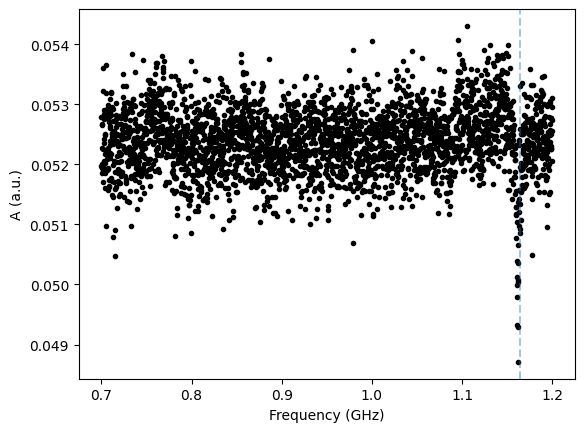

In [905]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

plt.axvline(1.164, linestyle = '--', alpha=0.4)
# plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(abs(qspec_res))]/1e9) + ' GHz')
plt.show()

In [845]:
measure_q.parameters.resonance_frequency_ge = 1.164e9
# measure_q.parameters.resonance_frequency_ge = 1.160e9
device_setup.set_calibration(
    measure_q.calibration()
)